In [10]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from reval.best_nclust_cv import FindBestClustCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering

In [2]:
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)

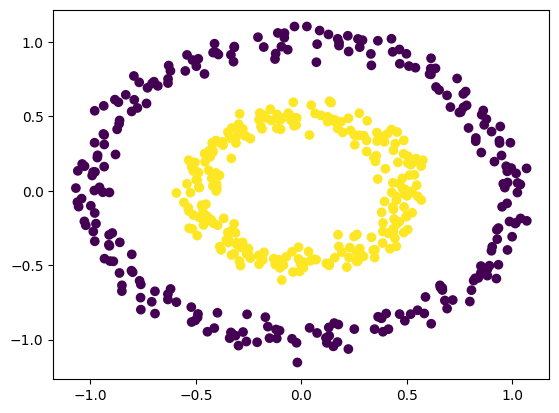

In [3]:
plt.scatter(*noisy_circles[0].T, c = noisy_circles[1])

In [4]:
X_tr, X_ts, = train_test_split(noisy_circles[0],
                                          test_size=0.25,
                                          random_state=42)

In [5]:
print(
    X_tr.shape, 
    X_ts.shape
)

(375, 2) (125, 2)


In [6]:
classifier = KNeighborsClassifier()
clustering = SpectralClustering(affinity='nearest_neighbors')
findbestclust = FindBestClustCV(nfold=2,
                                nclust_range=list(range(1, 8)),
                                s=classifier,
                                c=clustering,
                                n_jobs=4,
                                nrand=100)

In [7]:
metrics, nbest = findbestclust.best_nclust(X_tr, iter_cv=5)                             

KeyboardInterrupt: 

In [ ]:
out = findbestclust.evaluate(X_tr, X_ts, nbest)

/home/alberto/miniconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


/home/alberto/miniconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


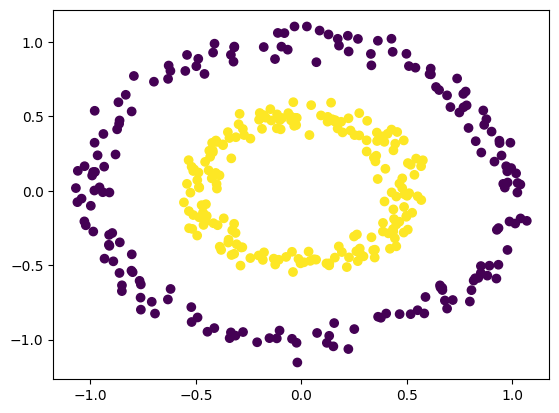

In [ ]:
spectr = SpectralClustering(n_clusters=2, affinity="nearest_neighbors", assign_labels="cluster_qr")
labels = spectr.fit_predict(X_tr)
plt.scatter(*X_tr.T, c = labels)

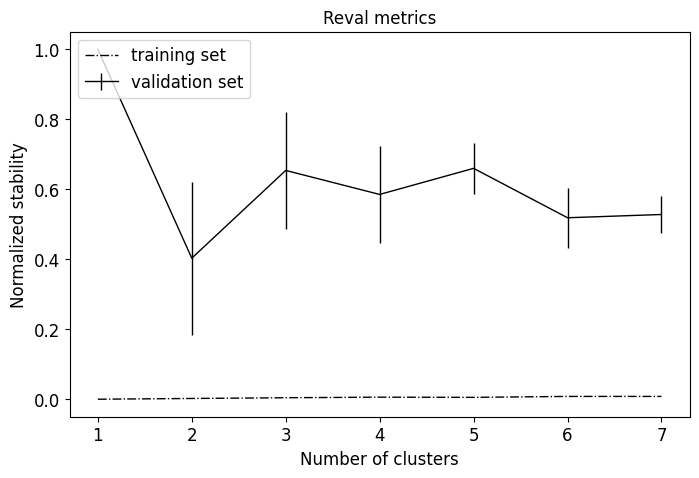

In [ ]:
from reval.visualization import plot_metrics
plot_metrics(metrics, title="Reval metrics")

# Apply to ispra


In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
from sklearn.metrics.pairwise import euclidean_distances
from tqdm.auto import tqdm
from pandas.tseries.offsets import MonthEnd
from  sklearn import decomposition
from sklearn.cluster import AgglomerativeClustering
from plotting import * 
from  matplotlib import colormaps as cmaps  
from scipy import stats 
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
from pandas.tseries.offsets import MonthEnd
from  matplotlib import colormaps as cmaps 
import json
from sklearn import metrics
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import SpectralClustering
from itertools import combinations
from numba import njit, prange
from os import path
from sklearn.model_selection import train_test_split

/home/alberto/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open(path.expanduser("~") + "/sys_specific.json") as file: 
    params = json.load(file)
_HOME_ = params["home"] + "/PHD"
import modify_dataset

In [3]:
phyto_abundances = pd.read_csv(_HOME_ + "/MSFD/Data/Modulo1/phyto_abund_modified.csv", index_col=0)
phyto_abundances.loc[:, "Date"] = pd.to_datetime(phyto_abundances["Date"])

In [4]:
with open(_HOME_ + "/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params

In [5]:
phyto_abund_simplified = modify_dataset.make_simplified_dataset(phyto_abundances, 0.7)
phyto_abund_simplified = modify_dataset.add_season_column(phyto_abund_simplified, seasons)
phyto_abund_simplified = modify_dataset.add_coast_dist_column(phyto_abund_simplified)
phyto_abund_simplified["Date"] = pd.to_datetime(phyto_abund_simplified["Date"]) + MonthEnd(0)
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = ordered_regions, ordered = True)

In [6]:
phyto_abund_simplified = phyto_abund_simplified.loc[:,
                                                    ["Region", "id", "Longitude", "Latitude", "Closest_coast", "Coast_dist", "Date", "Season_year", "Season", "Sample_depth", "Taxon", "Num_cell_l", "file_name"]
                                                    ]

In [7]:
higher_than_class = ['Other phytoplankton', "Haptophyta", "Noctilucea", "Non flagellates"]
sites_species = phyto_abund_simplified.set_index(["id", "Date"]).loc[:, ["Taxon", "Num_cell_l"]].query("Taxon not in @higher_than_class").pivot_table(index = ["id", "Date"], columns="Taxon", values = "Num_cell_l", fill_value=0)

In [8]:
abund_hellinger = sites_species.apply(lambda x: np.sqrt(x / sum(x)), axis = 1)
X = abund_hellinger.to_numpy()
X_transformed = X

In [11]:
X_tr, X_ts, = train_test_split(X_transformed,
                                          test_size=0.25,
                                          random_state=42)

In [11]:
classifier = KNeighborsClassifier()
clustering = AgglomerativeClustering(metric = "euclidean", linkage = "ward", compute_distances = True, compute_full_tree=True)
findbestclust = FindBestClustCV(nfold=2,
                                nclust_range=list(range(2, 3)),
                                s=classifier,
                                c=clustering,
                                n_jobs=4,
                                nrand=100)

In [ ]:
metrics, nbest = findbestclust.best_nclust(X_tr, iter_cv=5)    

In [17]:

from sklearn.cluster import SpectralClustering
# Assuming you have a data matrix X
hell_dist = euclidean_distances(X)
sigma_2 = np.var(hell_dist)
spectral_clustering = SpectralClustering(n_clusters= 3, affinity = "rbf", gamma = 1 / (2 * 4), assign_labels="cluster_qr")


In [29]:
np.arange(0.5, 5, 0.5)

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5])